In [2]:
import pandas as pd
import sklearn

from sklearn         import tree
from sklearn         import neighbors
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from datetime import date
import numpy as np
from scipy.stats.mstats   import winsorize
from scipy.stats          import pearsonr
import datetime as dt
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scikitplot as skplt
from pandas               import DataFrame
from pandas               import read_csv
from pandas               import Series
from numpy                import array
from numpy                import random
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score
from matplotlib           import pyplot
from scipy.stats          import pearsonr
import warnings
warnings.filterwarnings("ignore")
import sqldf
from sklearn.ensemble       import GradientBoostingClassifier

In [3]:
campaigns = pd.read_csv("campaigns.csv", sep=';')
donors = pd.read_csv("donors.csv")
gifts = pd.read_csv("gifts.csv")
camp6169 = pd.read_csv("selection campaign 6169.csv")
camp7244 = pd.read_csv("selection campaign 7244.csv")

# Data Exploration

In [4]:
print(campaigns.info())
print(campaigns.shape)
campaigns.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB
None
(367, 4)


,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [5]:
campaigns[campaigns['campaignID'] == 6169]

,campaignID,date,lettersSent,CostUnit
335,6169,04/09/2018,34 888,"0,87 €"


In [6]:
campaigns[campaigns['campaignID'] == 7244]

,campaignID,date,lettersSent,CostUnit
354,7244,18/06/2019,25 645,"0,55 €"


In [7]:
donors = donors.drop(['Unnamed: 0'], axis=1)   
print(donors.info())
print(donors.shape)
donors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donorID      44691 non-null  int64  
 1   zipcode      44689 non-null  float64
 2   province     44691 non-null  object 
 3   region       44691 non-null  object 
 4   gender       44659 non-null  object 
 5   language     44691 non-null  object 
 6   dateOfBirth  44691 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.4+ MB
None
(44691, 7)


,donorID,zipcode,province,region,gender,language,dateOfBirth
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [8]:
gifts = gifts.drop(['Unnamed: 0'], axis=1)   
print(gifts.info())
print(gifts.shape)
gifts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     216594 non-null  int64  
 1   campaignID  200957 non-null  float64
 2   amount      216594 non-null  object 
 3   date        216594 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.6+ MB
None
(216594, 4)


,donorID,campaignID,amount,date
0,100001,NaN,"12,39",2004-03-23
1,100001,1577.0,"12,39",2007-10-11
2,100001,1634.0,"6,69",2007-12-28
3,100001,1778.0,"24,79",2008-06-14
4,100001,1808.0,"7,44",2008-07-09


In [9]:
print(camp6169.info())
print(camp6169.shape)
camp6169.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   donorID  34888 non-null  int64
dtypes: int64(1)
memory usage: 272.7 KB
None
(34888, 1)


,donorID
0,100001
1,100002
2,100004
3,100008
4,100009


In [10]:
print(camp7244.info())
print(camp7244.shape)
camp7244.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   donorID  25645 non-null  int64
dtypes: int64(1)
memory usage: 200.5 KB
None
(25645, 1)


,donorID
0,100001
1,100002
2,100008
3,100009
4,100010


# Data Preparation - Train

In [11]:
#Crosscheck campaign and donor totals
print(camp6169.shape)
campaigns.loc[campaigns['campaignID'] == 6169, 'lettersSent']

(34888, 1)


335    34 888
Name: lettersSent, dtype: object

Donors Table

In [12]:
#Fix the province category in donor table and make dummy variables for the provinces
donors['province'] = donors['province'].str.title() 

donors = donors.join(pd.get_dummies(donors['province'], prefix="prov", drop_first = False))
donors = donors.drop(['province','prov_Missing'], axis=1) 

#Make dummy variables for Gender and drop original
donors['gender'] = donors['gender'].fillna("Gender Missing")
donors = donors.join(pd.get_dummies(donors['gender'], drop_first = False))
donors = donors.drop(['gender', "Gender Missing"], axis=1) 
donors = donors.rename(columns = {'M': 'Male', 'F': 'Female'})


#Make dummy variables for Language and drop original
donors = donors.join(pd.get_dummies(donors['language'], prefix="lang", drop_first = True))
donors = donors.drop(['language'], axis=1) 

#Format the date of birth column
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'], format="%m/%d/%Y")

#Drop unwanted columns
donors = donors.drop(['zipcode', 'region'], axis=1) 



Merge Donors & Camp6169

In [13]:
#Merge donor and camp6169
train = pd.merge(camp6169, donors, how = 'left', on = 'donorID')


Gifts Table

In [14]:
#Filter the gifts dataset to only take data before August 4th 2018 (drop date is Sept)
gifts['date'] = pd.to_datetime(gifts['date'], format="%Y/%m/%d")

gifts18 = gifts[gifts['date'] < '2018-08-04'].copy(deep=True)

#Convert the amount column to float
gifts18['amount'] = gifts18['amount'].str.replace(',','.').astype(float)


#Extract the latest donation date for each donor
latestdate = gifts18.groupby('donorID')['date'].agg('max')


#Extract the first donation date for each donor
firstdate = gifts18.groupby('donorID')['date'].agg('min')


#Compute statistics on the gift amount per donor
stats = gifts18.groupby('donorID')['amount'].agg(['count', 'sum', 'mean','std', 'min', 'max'])

#merge gifts18 with latestdate, firstdate stats and count_more_than_30

gifts18 = pd.merge(gifts18, latestdate, how = 'left', on = 'donorID')

gifts18 = pd.merge(gifts18, firstdate, how = 'left', on = 'donorID')

gifts18 = pd.merge(gifts18, stats, how = 'left', on = 'donorID')



#Rename Columns
gifts18 = gifts18.rename(columns = {'date_x': 'date', 'date_y': 'latestdate', 'date': 'firstdate', 'count': 'frequency'})


#Calculate Recency
gifts18['recency'] =  gifts18['latestdate'].apply(lambda x: pd.to_datetime('2018-8-4', format="%Y/%m/%d") - x)

#Convert recency to integer
#Refernce: https://stackoverflow.com/questions/25646200/python-convert-timedelta-to-int-in-a-dataframe
gifts18['recency'] = gifts18['recency'].dt.days.astype('int16')


#Calculate Active period (time between first and last donation)
gifts18['active_period'] = gifts18['latestdate'] - gifts18['firstdate']

#Convert active period to integer
gifts18['active_period'] = gifts18['active_period'].dt.days.astype('int16')

#Make dummy for frequency of donations greater than 30
gifts18["freq_donated>30"] = gifts18['amount'].apply(lambda a: int(a >= 30))


#Calculate amount donated in campaigns only
incampaignsonly = sqldf.run("""

select

DonorID, sum(amount) as donation_in_campaign_only

from gifts18
where campaignID IS NOT NULL
group by DonorID

""")

#Merge gifts18 with incampaignsonly
gifts18 = pd.merge(gifts18, incampaignsonly, how = 'left', on = 'donorID')

#Drop unwanted columns
gifts18 = gifts18.drop(['campaignID', 'amount', 'date'], axis=1) 


#Calculate donations and frequency in past 1 year

gifts_1year = gifts[(gifts['date'] > '2017-08-04') & (gifts['date'] < '2018-08-04')]

gifts_1year['amount'] = gifts_1year['amount'].str.replace(',','.').astype(float)

gifts_1year = gifts_1year.groupby('donorID')['amount'].agg(['sum', 'count'])

gifts_1year = gifts_1year.rename(columns = {'sum': 'donation_last1year', 'count': 'frequency_last1year'})


#Calculate donations and frequency in past 3 year

gifts_3year = gifts[(gifts['date'] > '2015-08-04') & (gifts['date'] < '2018-08-04')]

gifts_3year['amount'] = gifts_3year['amount'].str.replace(',','.').astype(float)

gifts_3year = gifts_3year.groupby('donorID')['amount'].agg(['sum', 'count'])

gifts_3year = gifts_3year.rename(columns = {'sum': 'donation_last3years', 'count' : 'frequency_last3years'})


#Calculate donations and frequency in past 5 years

gifts_5year = gifts[(gifts['date'] > '2013-08-04') & (gifts['date'] < '2018-08-04')]

gifts_5year['amount'] = gifts_5year['amount'].str.replace(',','.').astype(float)

gifts_5year = gifts_5year.groupby('donorID')['amount'].agg(['sum', 'count'])

gifts_5year = gifts_5year.rename(columns = {'sum': 'donation_last5years', 'count' : 'frequency_last5years'})

#merge gifts18 with donations from last 1, 3, and 5 years

gifts18 = pd.merge(gifts18, gifts_1year, how = 'left', on = 'donorID')
gifts18 = pd.merge(gifts18, gifts_3year, how = 'left', on = 'donorID')
gifts18 = pd.merge(gifts18, gifts_5year, how = 'left', on = 'donorID')


#Drop full duplicate columns
gifts18.drop_duplicates(inplace=True, subset = ['donorID'])


#Reset the index after dropping
gifts18.reset_index(drop=True, inplace=True)



Merge gifts with combined donors & camp6169

In [15]:
#Merge gifts18 with the combined donors and camp6169 table
train = pd.merge(train, gifts18, how = 'left', on='donorID')



Handle missing values and outliers

In [16]:
#Drop the values where donation amount is missing
train.dropna(subset = ['sum'], inplace=True)

#Reset the index after dropping
train.reset_index(drop=True, inplace=True)

#Fill Nan with 0 where applicable
train['std'] = train['std'].fillna(0)
train['donation_in_campaign_only'] = train['donation_in_campaign_only'].fillna(0)


#Fill Nan in donation window columns
train['donation_last5years'] = train['donation_last5years'].fillna(0)
train['donation_last3years'] = train['donation_last3years'].fillna(0)
train['donation_last1year'] = train['donation_last1year'].fillna(0)
train['frequency_last5years'] = train['frequency_last5years'].fillna(0)
train['frequency_last3years'] = train['frequency_last3years'].fillna(0)
train['frequency_last1year'] = train['frequency_last1year'].fillna(0)


#Treating outliers
train["sum"] = winsorize(np.array(train["sum"]), limits=[0.00, 0.001])

#Calculate client age at the time of campaign 6169
#Reference = https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python
train['age'] = train['dateOfBirth'].apply(lambda d: 2018 - d.year)

#Calculate age group
train['age_group'] = 'Seniors'
train.loc[(train['age'] >= 0) & (train['age'] <= 14), 'age_group'] = 'Children'
train.loc[(train['age'] >= 15) & (train['age'] <= 24), 'age_group'] = 'Youth'
train.loc[(train['age'] >= 25) & (train['age'] <= 64), 'age_group'] = 'Adults'

#Make dummy variables for age group and drop original
train = train.join(pd.get_dummies(train['age_group'], drop_first = False))
train = train.drop(['age_group', 'Youth'], axis=1)

#Drop unwanted columns
train = train.drop(['dateOfBirth'], axis=1)


Target Variable

In [17]:
#Creating target variable (people who actually donated to campaign 6169)
gifts6169 = gifts[gifts['campaignID'] == 6169]

#Convert the amount column to float
gifts6169['amount'] = gifts6169['amount'].str.replace(',','.').astype(float)

#Creating dummy for donors who donated greater than or equal to 30
gifts6169["donated>30"] = gifts6169['amount'].apply(lambda a: int(a >= 30))

#Drop unnecessary columns
gifts6169 = gifts6169.drop(['campaignID', 'amount', 'date'], axis=1) 


Add Target Variable to Train

In [18]:
#Merge train with the target variable
train = pd.merge(train, gifts6169, how = 'left', on='donorID')

#Fill the missing values in the target variable with 0. 1:donated more than 30; 0: donated less than 30 or not at all 
train['donated>30'] = train['donated>30'].fillna(0)
train['donated>30'] = train['donated>30'].astype(int)

In [19]:
train['donated>30'].value_counts()

0    33919
1      950
Name: donated>30, dtype: int64

# Data Preparation - Test

In [20]:
#Crosscheck campaign and donor totals
print(camp7244.shape)
campaigns.loc[campaigns['campaignID'] == 7244, 'lettersSent']

(25645, 1)


354    25 645
Name: lettersSent, dtype: object

Merge Donors & Camp7244

In [21]:
#Merge donor and camp7244
test = pd.merge(camp7244, donors, how = 'left', on = 'donorID')


Gifts Table

In [22]:
#Filter the gifts dataset to only take data before May 18th 2019 (drop date is June)
gifts['date'] = pd.to_datetime(gifts['date'], format="%Y/%m/%d")

gifts19 = gifts[gifts['date'] < '2019-05-18'].copy(deep=True)


#Convert the amount column to float
gifts19['amount'] = gifts19['amount'].str.replace(',','.').astype(float)


#Extract the latest donation date for each donor
latestdate = gifts19.groupby('donorID')['date'].agg('max')


#Extract the first donation date for each donor
firstdate = gifts19.groupby('donorID')['date'].agg('min')


#Compute statistics on the gift amount per donor
stats = gifts19.groupby('donorID')['amount'].agg(['count', 'sum', 'mean','std', 'min', 'max'])

#merge gifts19 with latestdate, firstdate and stats

gifts19 = pd.merge(gifts19, latestdate, how = 'left', on = 'donorID')

gifts19 = pd.merge(gifts19, firstdate, how = 'left', on = 'donorID')

gifts19 = pd.merge(gifts19, stats, how = 'left', on = 'donorID')



#Rename Columns
gifts19 = gifts19.rename(columns = {'date_x': 'date', 'date_y': 'latestdate', 'date': 'firstdate', 'count': 'frequency'})


#Calculate Recency
gifts19['recency'] =  gifts19['latestdate'].apply(lambda x: pd.to_datetime('2019-5-18', format="%Y/%m/%d") - x)

#Convert recency to integer
#Refernce: https://stackoverflow.com/questions/25646200/python-convert-timedelta-to-int-in-a-dataframe
gifts19['recency'] = gifts19['recency'].dt.days.astype('int16')


#Calculate Active period (time between first and last donation)
gifts19['active_period'] = gifts19['latestdate'] - gifts19['firstdate']

#Convert active period to integer
gifts19['active_period'] = gifts19['active_period'].dt.days.astype('int16')

#Make dummy for frequency of donations greater than 30
gifts19["freq_donated>30"] = gifts19['amount'].apply(lambda a: int(a >= 30))


#Calculate amount donated in campaigns only
incampaignonly = sqldf.run("""

select

DonorID, sum(amount) as donation_in_campaign_only

from gifts19
where campaignID IS NOT NULL
group by DonorID

""")

#Merge gifts19 with incampaignonly
gifts19 = pd.merge(gifts19, incampaignonly, how = 'left', on = 'donorID')


#Drop unwanted column
gifts19 = gifts19.drop(['amount', 'campaignID', 'date'], axis=1)   #drop campid and amoutn


#Calculate donations in past 1 year

gift_1year = gifts[(gifts['date'] > '2018-05-18') & (gifts['date'] < '2019-05-18')]

gift_1year['amount'] = gift_1year['amount'].str.replace(',','.').astype(float)

gift_1year = gift_1year.groupby('donorID')['amount'].agg(['sum', 'count'])

gift_1year = gift_1year.rename(columns = {'sum': 'donation_last1year', 'count': 'frequency_last1year'})


#Calculate donations in past 3 year

gift_3year = gifts[(gifts['date'] > '2016-05-18') & (gifts['date'] < '2019-05-18')]

gift_3year['amount'] = gift_3year['amount'].str.replace(',','.').astype(float)

gift_3year = gift_3year.groupby('donorID')['amount'].agg(['sum' ,'count'])

gift_3year = gift_3year.rename(columns = {'sum': 'donation_last3years', 'count': 'frequency_last3years'})


#Calculate donations in past 5 years

gift_5year = gifts[(gifts['date'] > '2014-05-18') & (gifts['date'] < '2019-05-18')]

gift_5year['amount'] = gift_5year['amount'].str.replace(',','.').astype(float)

gift_5year = gift_5year.groupby('donorID')['amount'].agg(['sum', 'count'])

gift_5year = gift_5year.rename(columns = {'sum': 'donation_last5years', 'count': 'frequency_last5years'})

#merge gifts19 with donations from last 1, 3, and 5 years

gifts19 = pd.merge(gifts19, gift_1year, how = 'left', on = 'donorID')
gifts19 = pd.merge(gifts19, gift_3year, how = 'left', on = 'donorID')
gifts19 = pd.merge(gifts19, gift_5year, how = 'left', on = 'donorID')


#Drop full duplicate columns
gifts19.drop_duplicates(inplace=True, subset = ['donorID'])


#Reset the index after dropping
gifts19.reset_index(drop=True, inplace=True)


Merge gifts with combined donors & camp7244

In [23]:
#Merge gifts19 with the combined donors and camp7244 table
test = pd.merge(test, gifts19, how = 'left', on='donorID')

Handle missing values and outliers

In [24]:
#Drop the values where donation amount is missing
test.dropna(subset = ['sum'], inplace=True)

#Reset the index after dropping
test.reset_index(drop=True, inplace=True)

#Fill Nan with 0 where applicable
test['std'] = test['std'].fillna(0)
test['donation_in_campaign_only'] = test['donation_in_campaign_only'].fillna(0)

#Fill Nan in donation window columns
test['donation_last5years'] = test['donation_last5years'].fillna(0)
test['donation_last3years'] = test['donation_last3years'].fillna(0)
test['donation_last1year'] = test['donation_last1year'].fillna(0)
test['frequency_last5years'] = test['frequency_last5years'].fillna(0)
test['frequency_last3years'] = test['frequency_last3years'].fillna(0)
test['frequency_last1year'] = test['frequency_last1year'].fillna(0)

#Treating outliers
test["sum"] = winsorize(np.array(test["sum"]), limits=[0.00, 0.001])

#Calculate client age at the time of campaign 7244
#Reference = https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python
test['age'] = test['dateOfBirth'].apply(lambda d: 2019 - d.year)

#Calculate age group
test['age_group'] = 'Seniors'
test.loc[(test['age'] >= 0) & (test['age'] <= 14), 'age_group'] = 'Children'
test.loc[(test['age'] >= 15) & (test['age'] <= 24), 'age_group'] = 'Youth'
test.loc[(test['age'] >= 25) & (test['age'] <= 64), 'age_group'] = 'Adults'

#Make dummy variables for age group, drop original and one of the dummies
test = test.join(pd.get_dummies(test['age_group'], drop_first = False))
test = test.drop(['age_group', 'Youth'], axis=1)

#Drop unwanted columns
test = test.drop(['dateOfBirth'], axis=1)


Target Variable

In [25]:
#Creating target variable (people who actually donated to campaign 7244)
gifts7244 = gifts[gifts['campaignID'] == 7244]

#Convert the amount column to float
gifts7244['amount'] = gifts7244['amount'].str.replace(',','.').astype(float)

#Creating dummy for donors who donated greater than or equal to 30
gifts7244["donated>30"] = gifts7244['amount'].apply(lambda a: int(a >= 30))

#Drop unnecessary columns
gifts7244 = gifts7244.drop(['campaignID', 'amount', 'date'], axis=1) 

Add Target Variable to Test

In [26]:
#Merge test with the target variable
test = pd.merge(test, gifts7244, how = 'left', on='donorID')

#Fill the missing values in the target variable with 0. 1:donated more than 30; 0: donated less than 30 or not at all 
test['donated>30'] = test['donated>30'].fillna(0)
test['donated>30'] = test['donated>30'].astype(int)

In [27]:
test['donated>30'].value_counts()

0    25427
1      217
Name: donated>30, dtype: int64

In [28]:
selectedFeatures = []
target = "donated>30"

for column in train.columns:
    if column not in ("donorID","donated>30", "latestdate", "firstdate", "prov_Missing"):
        (pearson,pvalue) = pearsonr(train[column],train[target])
        print(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.05 else 0}")
        if pvalue < 0.05:
            selectedFeatures.append(column)

prov_Antwerp - p-vlue = 0.7431823229055732 - selected : 0
prov_Brussels - p-vlue = 0.09313763507233452 - selected : 0
prov_East Flanders - p-vlue = 0.15991603033270246 - selected : 0
prov_Flemish Brabant - p-vlue = 0.4689874963573519 - selected : 0
prov_Hainaut - p-vlue = 0.03323577030220531 - selected : 1
prov_Liege - p-vlue = 0.5117456926233549 - selected : 0
prov_Limburg - p-vlue = 0.17927271136308384 - selected : 0
prov_Luxembourg - p-vlue = 0.9749177801553895 - selected : 0
prov_Namur - p-vlue = 0.6138383996790112 - selected : 0
prov_Walloon Brabant - p-vlue = 0.015028458992795537 - selected : 1
prov_West Flanders - p-vlue = 0.2931579398601259 - selected : 0
Female - p-vlue = 3.876772241108561e-92 - selected : 1
Male - p-vlue = 8.998212259741483e-92 - selected : 1
lang_FR - p-vlue = 0.008246063599525288 - selected : 1
lang_NL - p-vlue = 0.011135246101660772 - selected : 1
frequency - p-vlue = 0.27365324533750257 - selected : 0
sum - p-vlue = 9.928411931056958e-07 - selected : 1
me

In [29]:
selectedFeatures.remove('Adults')
selectedFeatures.remove('Seniors')
selectedFeatures.extend(['prov_Antwerp', 'prov_Brussels', 'prov_East Flanders',
       'prov_Flemish Brabant', 'prov_Liege', 'prov_Limburg',
       'prov_Luxembourg', 'prov_Namur',
       'prov_West Flanders'])

In [30]:
selectedFeatures

['prov_Hainaut',
 'prov_Walloon Brabant',
 'Female',
 'Male',
 'lang_FR',
 'lang_NL',
 'sum',
 'recency',
 'active_period',
 'freq_donated>30',
 'donation_last3years',
 'donation_last5years',
 'age',
 'prov_Antwerp',
 'prov_Brussels',
 'prov_East Flanders',
 'prov_Flemish Brabant',
 'prov_Liege',
 'prov_Limburg',
 'prov_Luxembourg',
 'prov_Namur',
 'prov_West Flanders']

# Logistic Regression

In [31]:
model = LogisticRegression(solver = "lbfgs", max_iter = 4000)

model.fit(train[selectedFeatures],train[target])

print(model.coef_)
print(model.intercept_)


[[-4.04206986e-01 -2.42238413e-01 -7.54318080e-01 -2.13912560e+00
  -1.55424619e+00 -1.37062281e+00 -1.44301536e-04 -3.88294613e-05
   2.26030823e-04  8.96616596e-01 -9.51559006e-04  3.79289406e-04
   3.53519816e-02 -3.13565513e-01 -4.12332922e-01 -1.94569288e-01
  -2.06007957e-01 -2.59101587e-01 -4.13201302e-01 -9.77795409e-02
  -1.49514343e-01 -2.34393174e-01]]
[-2.93165314]


In [32]:
# predict probabilities

LR_pred_train = model.predict_proba(train[selectedFeatures])
LR_pred_test =  model.predict_proba(test[selectedFeatures])

train["lr proba donate"] = pd.DataFrame(LR_pred_train)[1]
test["lr proba donate"] = pd.DataFrame(LR_pred_test)[1]

In [33]:
#AUC
LR_aucTrain = roc_auc_score(np.array(train[target]),np.array(train["lr proba donate"]))
LR_aucTest = roc_auc_score(np.array(test[target]),np.array(test["lr proba donate"]))

print("AUC Train:", LR_aucTrain)
print("AUC Test:", LR_aucTest)

AUC Train: 0.7658833350660476
AUC Test: 0.650598016296404


In [34]:
from sklearn.metrics    import roc_curve

def roc (dataSet: DataFrame, actuals: str, probability: str) -> DataFrame:

    (fpr,tpr,threshold) = roc_curve(array(dataSet[actuals]), array(dataSet[probability]), pos_label = 1)

    returnData = DataFrame(tpr)
    returnData.columns = ["True positive rate"]
    returnData["False positive rate"] = DataFrame(fpr)

    return returnData

Text(0.5, 1.0, 'Receiver Operating Characteristic')

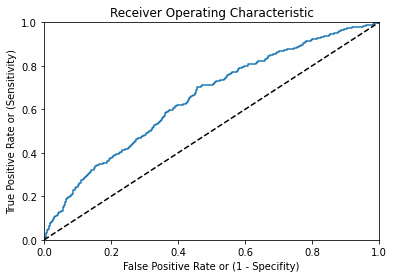

In [35]:
#ROC Curve

rocTest     = roc(dataSet = test,     actuals = "donated>30", probability = "lr proba donate")

pyplot.plot(rocTest["False positive rate"], rocTest["True positive rate"])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic")

Text(69.0, 0.5, 'Truth')

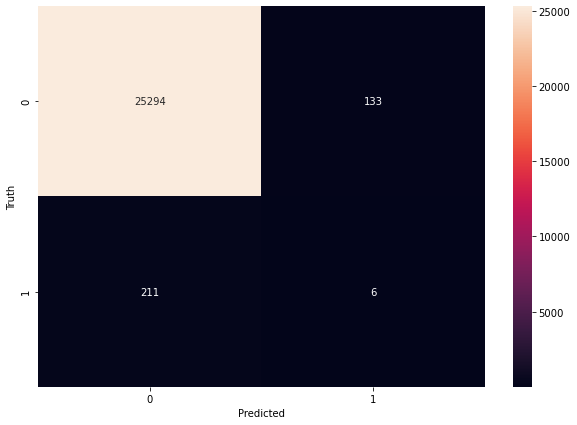

In [36]:
import tensorflow as tf

import seaborn as sn



pred = np.where(test["lr proba donate"]>0.2,1,0)



matrix = tf.math.confusion_matrix(labels=test[target],predictions=pred)



plt.figure(figsize = (10,7))

sn.heatmap(matrix, annot=True, fmt='d')

plt.xlabel('Predicted')

plt.ylabel('Truth')

# Random Forest

In [37]:
rf = RandomForestClassifier(max_depth=3)

rf.fit(train[selectedFeatures],train[target])

RandomForestClassifier(max_depth=3)

In [38]:
# predict probabilities

RF_pred_train = rf.predict_proba(train[selectedFeatures])
RF_pred_test =  rf.predict_proba(test[selectedFeatures])

train["rf proba donate"] = pd.DataFrame(RF_pred_train)[1]
test["rf proba donate"] = pd.DataFrame(RF_pred_test)[1]



In [39]:
#AUC
RF_aucTrain = roc_auc_score(np.array(train[target]),np.array(train["rf proba donate"]))
RF_aucTest = roc_auc_score(np.array(test[target]),np.array(test["rf proba donate"]))

print("RF AUC Train:", RF_aucTrain)
print("RF AUC Test:", RF_aucTest)

RF AUC Train: 0.8015969313891764
RF AUC Test: 0.6759736330208156


Text(0.5, 1.0, 'Receiver Operating Characteristic')

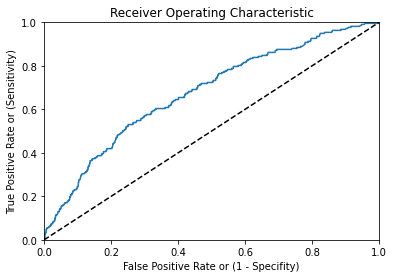

In [40]:
#ROC Curve

rocTest     = roc(dataSet = test,     actuals = "donated>30", probability = "rf proba donate")

pyplot.plot(rocTest["False positive rate"], rocTest["True positive rate"])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic")

# Boosted Tree

In [41]:
boostedTree  = GradientBoostingClassifier()
boostedTree.fit(train[selectedFeatures],train[target])

GradientBoostingClassifier()

In [42]:
# predict probabilities

BT_pred_train = boostedTree.predict_proba(train[selectedFeatures])
BT_pred_test =  boostedTree.predict_proba(test[selectedFeatures])

train["bt proba donate"] = pd.DataFrame(BT_pred_train)[1]
test["bt proba donate"] = pd.DataFrame(BT_pred_test)[1]

In [43]:
#AUC
BT_aucTrain = roc_auc_score(np.array(train[target]),np.array(train["bt proba donate"]))
BT_aucTest = roc_auc_score(np.array(test[target]),np.array(test["bt proba donate"]))

print("AUC Train:", BT_aucTrain)
print("AUC Test:", BT_aucTest)

AUC Train: 0.9298930889534045
AUC Test: 0.6784690753814253


Text(0.5, 1.0, 'Receiver Operating Characteristic')

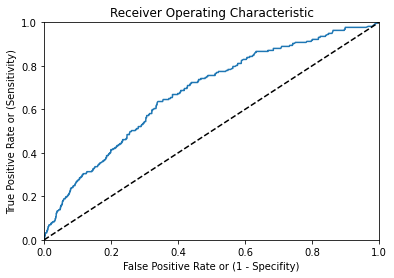

In [44]:
#ROC Curve

rocTest     = roc(dataSet = test,     actuals = "donated>30", probability = "bt proba donate")

pyplot.plot(rocTest["False positive rate"], rocTest["True positive rate"])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic")

# Lift, Gain, & Response for the Selected Logistic Regression Model

Functions

In [45]:
def equifrequentBinning (dataSet: DataFrame, byColumn: str, into: int) -> DataFrame:

    internalSet = dataSet

    quanitles = []

    for i in range(into):
        quanitles.append(1 / into * (i))

    quantile = internalSet.quantile(quanitles, axis = 0)[byColumn].to_dict()

    internalSet["Bin"] = 0

    for q in quantile:
        upperBound = quantile[q]
        internalSet.loc[internalSet[byColumn] >= upperBound, byColumn + "_bin"] = int(q * into +1)

    return internalSet


def lift (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    summary = cumulativeResponse(dataSet = dataSet, actuals = actuals, probability = probability, precision = precision)

    summary["Lift"] = summary["Cumulative response"] / Series(summary["Average response"]).max()
    summary["Base"] = summary["Average response"] / Series(summary["Average response"]).max()

    return summary[["Quantile","Lift","Base"]]

def cumulativeResponse (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    internalSet = equifrequentBinning (dataSet = dataSet[[actuals, probability]], byColumn = probability, into = precision)

    internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
    internalSet["obs"]      = 1

    summary = internalSet[["Quantile", actuals, "obs"]].groupby(["Quantile"], as_index = False).sum().sort_values(by = "Quantile", ascending = False)

    summary["cumulativeTarget"]     = Series(summary[actuals]).cumsum(skipna = False)
    summary["cumulativeAll"]        = Series(summary["obs"]).cumsum(skipna = False)
    summary["Cumulative response"]  = summary["cumulativeTarget"] / summary["cumulativeAll"]
    summary["Average response"]     = Series(summary["cumulativeTarget"]).max() / Series(summary["cumulativeAll"]).max()

    return summary[["Quantile","Cumulative response","Average response"]]

def cumulativeGains (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    internalSet = equifrequentBinning (dataSet = dataSet[[actuals, probability]], byColumn = probability, into = precision)

    internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
    internalSet["obs"]      = 1

    summary = internalSet[["Quantile", actuals, "obs"]].groupby(["Quantile"], as_index = False).sum().sort_values(by = "Quantile", ascending = False)

    summary["cumulativeTarget"]     = Series(summary[actuals]).cumsum(skipna = False)
    summary["cumulativeAll"]        = Series(summary["obs"]).cumsum(skipna = False)
    summary["Cumulative gains"]     = summary["cumulativeTarget"] / Series(summary["cumulativeTarget"]).max()
    summary["Base"]                 = summary["Quantile"]

    return summary[["Quantile","Cumulative gains","Base"]]




In [46]:
CumulativeResponse = cumulativeResponse (test, "donated>30", "lr proba donate")

In [47]:
CumulativeGains = cumulativeGains(test, "donated>30", "lr proba donate")

In [48]:
Lift = lift(test, "donated>30", "lr proba donate")

Text(0.5, 1.0, 'Lift')

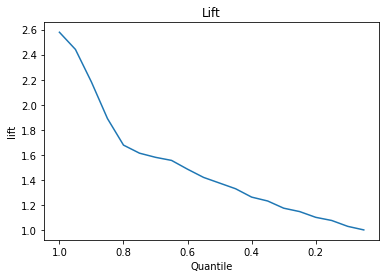

In [49]:
pyplot.plot(Lift["Quantile"], Lift["Lift"])
plt.gca().invert_xaxis()
pyplot.xlabel("Quantile")
pyplot.ylabel("lift")
pyplot.title("Lift")

Text(0.5, 1.0, 'Cumulative Gains')

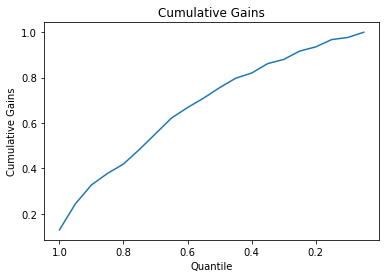

In [50]:
pyplot.plot(CumulativeGains["Quantile"], CumulativeGains["Cumulative gains"])
pyplot.gca().invert_xaxis()
pyplot.xlabel("Quantile")
pyplot.ylabel("Cumulative Gains")
pyplot.title("Cumulative Gains")

# Scoring the New Campaign Data

In [51]:
#Import the new campaign data
score = pd.read_csv("new_campaign_selection.csv")

Merge Donors & New Campaign 7362

In [52]:
#Merge donor and camp7362
score = pd.merge(score, donors, how = 'left', on = 'donorID')

Gifts Table

In [53]:
#Filter the gifts dataset to only take data before January 1st 2020 (drop date is Feb)
gifts['date'] = pd.to_datetime(gifts['date'], format="%Y/%m/%d")

gifts20 = gifts[gifts['date'] < '2020-01-01'].copy(deep=True)


#Convert the amount column to float
gifts20['amount'] = gifts20['amount'].str.replace(',','.').astype(float)


#Extract the latest donation date for each donor
latestdate = gifts20.groupby('donorID')['date'].agg('max')


#Extract the first donation date for each donor
firstdate = gifts20.groupby('donorID')['date'].agg('min')


#Compute statistics on the gift amount per donor
stats = gifts20.groupby('donorID')['amount'].agg(['count', 'sum', 'mean','std', 'min', 'max'])

#merge gifts20 with latestdate, firstdate and stats

gifts20 = pd.merge(gifts20, latestdate, how = 'left', on = 'donorID')

gifts20 = pd.merge(gifts20, firstdate, how = 'left', on = 'donorID')

gifts20 = pd.merge(gifts20, stats, how = 'left', on = 'donorID')



#Rename Columns
gifts20 = gifts20.rename(columns = {'date_x': 'date', 'date_y': 'latestdate', 'date': 'firstdate', 'count': 'frequency'})


#Calculate Recency
gifts20['recency'] =  gifts20['latestdate'].apply(lambda x: pd.to_datetime('2020-01-01', format="%Y/%m/%d") - x)

#Convert recency to integer
#Refernce: https://stackoverflow.com/questions/25646200/python-convert-timedelta-to-int-in-a-dataframe
gifts20['recency'] = gifts20['recency'].dt.days.astype('int16')


#Calculate Active period (time between first and last donation)
gifts20['active_period'] = gifts20['latestdate'] - gifts20['firstdate']

#Convert active period to integer
gifts20['active_period'] = gifts20['active_period'].dt.days.astype('int16')

#Make dummy for frequency of donations greater than 30
gifts20["freq_donated>30"] = gifts20['amount'].apply(lambda a: int(a >= 30))


#Calculate amount donated in campaigns only
incampaignonly = sqldf.run("""

select

DonorID, sum(amount) as donation_in_campaign_only

from gifts20
where campaignID IS NOT NULL
group by DonorID

""")

#Merge gifts20 with incampaignonly
gifts20 = pd.merge(gifts20, incampaignonly, how = 'left', on = 'donorID')


#Drop unwanted column
gifts20 = gifts20.drop(['amount', 'campaignID', 'date'], axis=1) 


#Calculate donations in past 1 year

gift_1year = gifts[(gifts['date'] > '2019-01-01') & (gifts['date'] < '2020-01-01')]

gift_1year['amount'] = gift_1year['amount'].str.replace(',','.').astype(float)

gift_1year = gift_1year.groupby('donorID')['amount'].agg(['sum', 'count'])

gift_1year = gift_1year.rename(columns = {'sum': 'donation_last1year', 'count': 'frequency_last1year'})


#Calculate donations in past 3 year

gift_3year = gifts[(gifts['date'] > '2017-01-01') & (gifts['date'] < '2020-01-01')]

gift_3year['amount'] = gift_3year['amount'].str.replace(',','.').astype(float)

gift_3year = gift_3year.groupby('donorID')['amount'].agg(['sum' ,'count'])

gift_3year = gift_3year.rename(columns = {'sum': 'donation_last3years', 'count': 'frequency_last3years'})


#Calculate donations in past 5 years

gift_5year = gifts[(gifts['date'] > '2015-01-01') & (gifts['date'] < '2020-01-01')]

gift_5year['amount'] = gift_5year['amount'].str.replace(',','.').astype(float)

gift_5year = gift_5year.groupby('donorID')['amount'].agg(['sum', 'count'])

gift_5year = gift_5year.rename(columns = {'sum': 'donation_last5years', 'count': 'frequency_last5years'})

#merge gifts20 with donations from last 1, 3, and 5 years

gifts20 = pd.merge(gifts20, gift_1year, how = 'left', on = 'donorID')
gifts20 = pd.merge(gifts20, gift_3year, how = 'left', on = 'donorID')
gifts20 = pd.merge(gifts20, gift_5year, how = 'left', on = 'donorID')


#Drop full duplicate columns
gifts20.drop_duplicates(inplace=True, subset = ['donorID'])


#Reset the index after dropping
gifts20.reset_index(drop=True, inplace=True)

Merge gifts20 with combined donor and new campaign data (7362)

In [54]:
#Merge gifts20 with the combined donors and camp7362 table
score = pd.merge(score, gifts20, how = 'left', on='donorID')

Handle missing values and outliers

In [55]:
#Drop the values where donation amount is missing
score.dropna(subset = ['sum'], inplace=True)

#Reset the index after dropping
score.reset_index(drop=True, inplace=True)

#Fill Nan with 0 where applicable
score['std'] = score['std'].fillna(0)
score['donation_in_campaign_only'] = score['donation_in_campaign_only'].fillna(0)

#Fill Nan in donation window columns
score['donation_last5years'] = score['donation_last5years'].fillna(0)
score['donation_last3years'] = score['donation_last3years'].fillna(0)
score['donation_last1year'] = score['donation_last1year'].fillna(0)
score['frequency_last5years'] = score['frequency_last5years'].fillna(0)
score['frequency_last3years'] = score['frequency_last3years'].fillna(0)
score['frequency_last1year'] = score['frequency_last1year'].fillna(0)

#Treating outliers
score["sum"] = winsorize(np.array(score["sum"]), limits=[0.00, 0.001])

#Calculate client age at the time of campaign 7362
#Reference = https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python
score['age'] = score['dateOfBirth'].apply(lambda d: 2020 - d.year)

#Calculate age group
score['age_group'] = 'Seniors'
score.loc[(score['age'] >= 0) & (score['age'] <= 14), 'age_group'] = 'Children'
score.loc[(score['age'] >= 15) & (score['age'] <= 24), 'age_group'] = 'Youth'
score.loc[(score['age'] >= 25) & (score['age'] <= 64), 'age_group'] = 'Adults'

#Make dummy variables for age group, drop original and one of the dummies
score = score.join(pd.get_dummies(score['age_group'], drop_first = False))
score = score.drop(['age_group', 'Youth'], axis=1)

#Drop unwanted columns
score = score.drop(['dateOfBirth'], axis=1)


Predict Probability of Donation 

In [56]:
score["proba_donation"] = pd.DataFrame(model.predict_proba(score[selectedFeatures]))[1]

In [57]:
score = score[['donorID', 'proba_donation']]

In [58]:
score.to_csv('Score.csv', index=False)

# Profiling

Based on Test Set

In [59]:
donors1 = pd.read_csv("donors.csv")
#Good donors: Gender, province and language
good_donors = test[test['lr proba donate']> 0.2]
good_donors_ids = pd.DataFrame(good_donors['donorID'])
good_donors = pd.merge(good_donors_ids, donors1, how='left', on= 'donorID')


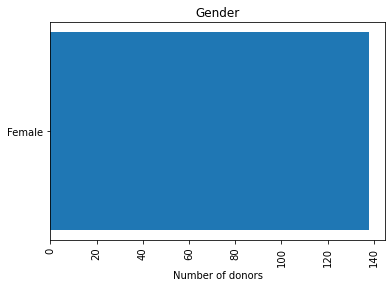

In [60]:
#Gender of good donors
good_donors['gender']=good_donors['gender'].replace({'F': 'Female','M': 'Male'})
gender = good_donors['gender'].value_counts()
plt.barh(gender.index, width=gender)
plt.title('Gender')
plt.xlabel('Number of donors')
plt.xticks(rotation = 90)
plt.show()

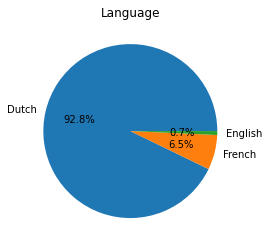

In [61]:
#language of good donors
good_donors['language']=good_donors['language'].replace({'NL': 'Dutch','EN': 'English', 'FR': 'French' })
language =good_donors ['language'].value_counts(normalize=True)
plt.pie(language, labels=language.index, autopct='%1.1f%%')
labels = ['English', 'French', 'NL']
plt.title('Language')
plt.show()

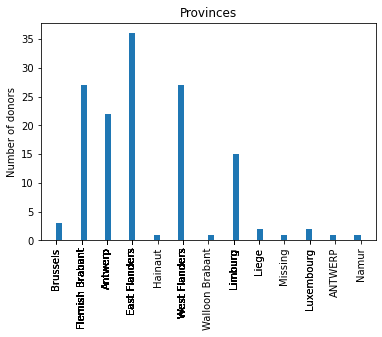

In [62]:
#Provinces in which good donors live
plt.hist(good_donors['province'], bins=50)
plt.title('Provinces')
plt.xticks(good_donors['province'], rotation='vertical')
plt.ylabel('Number of donors')
plt.show()

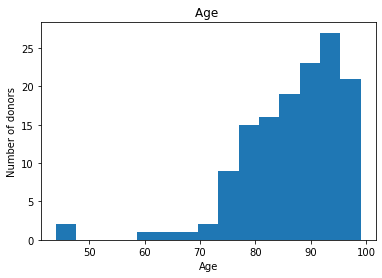

In [63]:
# Age of good donors
good_donors = test[test['lr proba donate']> 0.2 ] 
good__donors = good_donors[good_donors['age']< 100]
plt.hist(good__donors['age'], bins = 15)
plt.title('Age ')
plt.xlabel('Age')
plt.ylabel('Number of donors')
plt.show()

In [64]:
#Bad donors: Gender, province and language
bad_donors = test[test['lr proba donate']< 0.05]
bad_donors_ids = pd.DataFrame(bad_donors['donorID'])
bad__donors = pd.merge(bad_donors_ids, donors1, how='left', on= 'donorID')

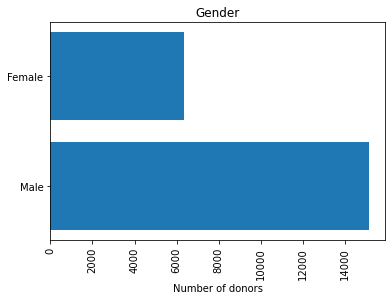

In [65]:
#Gender of bad donors
bad__donors['gender']=bad__donors['gender'].replace({'F': 'Female','M': 'Male'})
gender = bad__donors['gender'].value_counts()
plt.barh(gender.index, width=gender)
plt.title('Gender')
plt.xlabel('Number of donors')
plt.xticks(rotation = 90)
plt.show()

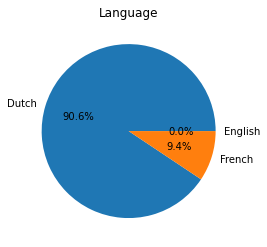

,language
Dutch,0.906429
French,0.093525
English,0.000047


In [66]:
#language of bad donors
bad__donors['language']=bad__donors['language'].replace({'NL': 'Dutch','EN': 'English', 'FR': 'French' })
language =bad__donors ['language'].value_counts(normalize=True)
plt.pie(language, labels=language.index, autopct='%1.1f%%')
plt.title('Language')
plt.show()
pd.DataFrame(language)

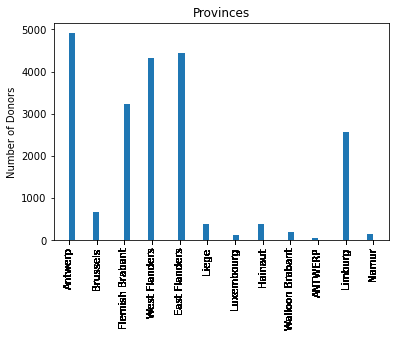

In [67]:
#Provinces in which bad donors live
plt.hist(bad__donors['province'], bins=50)
plt.title('Provinces')
plt.xticks(bad__donors['province'], rotation='vertical')
plt.ylabel('Number of Donors')
plt.show()


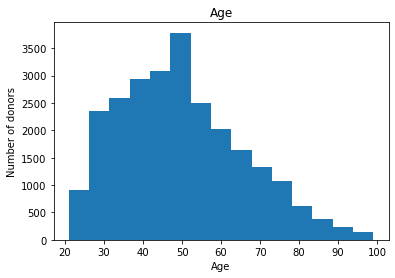

In [68]:
# Age of bad donors
bad_donors = test[test['lr proba donate']> 0.2]
bad_donors = test[test['age']< 100]
plt.hist(bad_donors['age'], bins = 15)
plt.title('Age')
plt.xlabel('Age')
plt.ylabel('Number of donors')
plt.show()